# Analiza modelu dla układu Lorentza
---

### Wprowadzenie

Układ Lorenza często pojawia się w pracach związanych z zagadnieniem predykcji z wykorzystaniem kwaternionów [*wpisać odnośniki do artykułów*]. W związku z powyższym w celach weryfikacyjnych zaproponowany model zastosowano również do tego układu. 

Układ (system) Lorenza, opisuje zmiany zachodzące w atmosferze pod wpływem promieniowania słonecznego, ogrzewającego powierzchnię Ziemi. Sam układ rozpatrywany jest w baniach z zakresu chaosu deterministycznego, który można traktować jako losowe zachowanie się przebiegów czasowych.

Systemy z zakresu teorii chaosu deterministycznego, wrażliwe są na warunki początkowe, niewielka ich zmiana może prowadzić w dłuższym horyzoncie do wielkich odchyleń. 

Przebiegi w układzie Lorenza charakteryzują się występowaniem atraktora tj. stan układu dynamicznego, do którego dąży układ.

**Układ Lorenza** (model opisujący zjawisko konwekcji termicznej w atmosferze)
$$
\dot{s}_L(t) = F(x(t)) 
$$
$$
s_L(t) = 
\begin{bmatrix}
x(t)\\ 
y(t)\\
z(t) 
\end{bmatrix}, 

F(x(t)) = 
\begin{bmatrix}
\sigma(y(t)-z(t))\\ 
\rho x(t) - y(t) - x(t)z(t)\\
x(t)y(t) - \beta z(t)
\end{bmatrix}
$$

Dla modelu konwekcji:

- $\sigma$ - liczba Prandtla charakteryzująca lepkość ośrodka,
- $\rho$ - liczba Rayleigha,
- $\beta$ - rozmiar obszaru, w którym zachodzi konwekcja.

Dla założonego modelu konwekcji $\sigma$ = 10, $\rho$=28, $\beta$=$\frac{8}{3}$

M. Busłowicz, *Analiza układu Lorenza niecałkowitego rzędu*, Wydział Elektryczny, Politechnika Białostocka, [http://yadda.icm.edu.pl/baztech/element/bwmeta1.element.baztech-article-BSW1-0104-0038]

---

In [1]:
import numpy as np
import quaternion as qt
import library.ulogReader as ur
import library.quaternionUtils as qu
import library.choleskyDecomposition as cd
import library.quaternionVisualisation as qv

import library.lorenzAttractor as la

#### Generate Lorenz Attractor

In [2]:
dt = 0.01           # 1/frequency sampling
num_steps = 10000   # Number of steps

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)             # Set initial values

for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + la.lorenz(xyzs[i]) * dt

### Plotting models

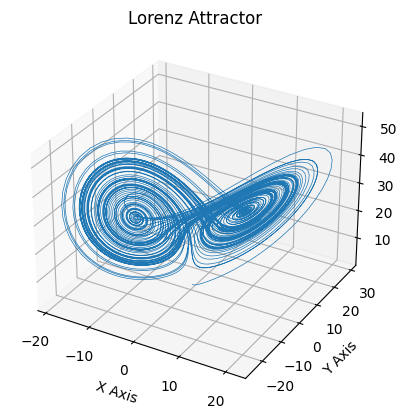

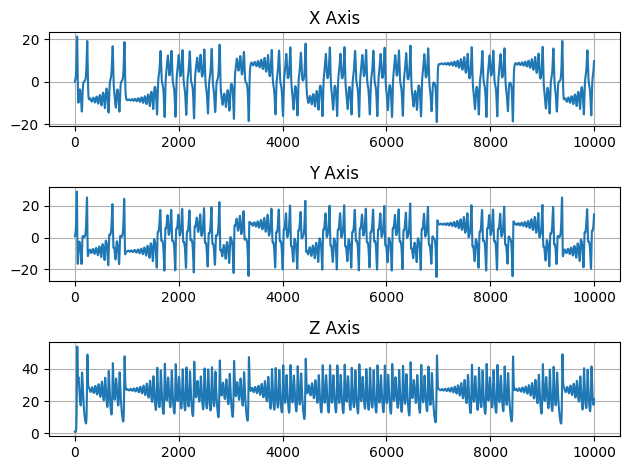

In [3]:
# 3D plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xyzs.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")
plt.show()

# Plot all components
TITLES = ["X Axis", "Y Axis", "Z Axis"]

for i, title in enumerate(TITLES):
    plt.subplot(3,1,i+1)
    plt.plot(xyzs[:,i])
    plt.title(title)
    plt.grid()
plt.tight_layout()
plt.show()

### Designating AR coefficients

In [17]:
P_ORDER    = 5 
K_FORECAST = [1,3,7]
N_WINDOW = 15            # Minimal value (N_WINDOW > P_ORDER + 1)
START_WINDOW = 30
MU = 1e-3

x = qu.eulerToQuaternion(xyzs, degrees = True)
y = np.ones((len(K_FORECAST), x.shape[0] + max(K_FORECAST)), dtype = qt.quaternion)

corr_matrix = qu.correlationMatrix(x[:START_WINDOW][::-1], P_ORDER + 1 , normalize=True)

for i in range(START_WINDOW, x.shape[0]+1):
    tmp_corr_matrix = qu.correlationMatrix(x[i-N_WINDOW : i][::-1], P_ORDER + 1, normalize=True)
    corr_matrix = (1-MU) * corr_matrix + MU * tmp_corr_matrix
    tmp_corr_matrix = np.copy(corr_matrix)
    np.fill_diagonal(tmp_corr_matrix, tmp_corr_matrix.diagonal()+qt.quaternion(1e-6,0,0,0))
    l = cd.choleskyDecomposition(tmp_corr_matrix[:-1, :-1])
    w = cd.solveLLHEquation(l, tmp_corr_matrix[1:,0])

    for k, k_steps in enumerate(K_FORECAST):
        y[k, i + k_steps - 1] = qu.predictionKSteps(np.copy(x[i-P_ORDER : i][::-1]), w, k_steps)

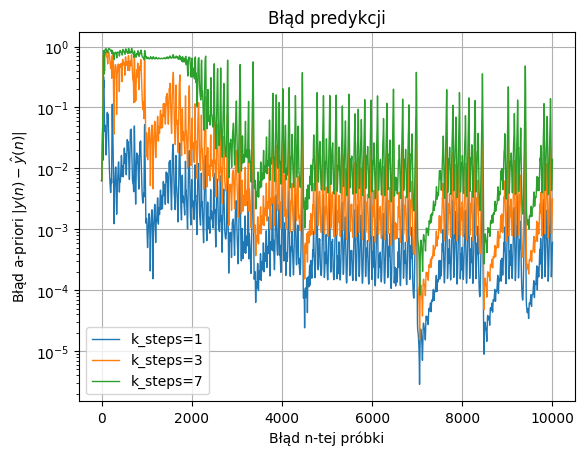

In [18]:
qv.displayPredictionError(x,y,K_FORECAST)

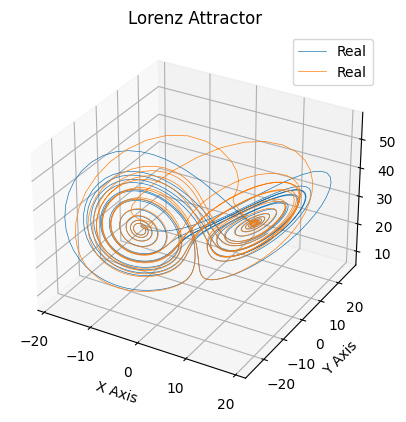

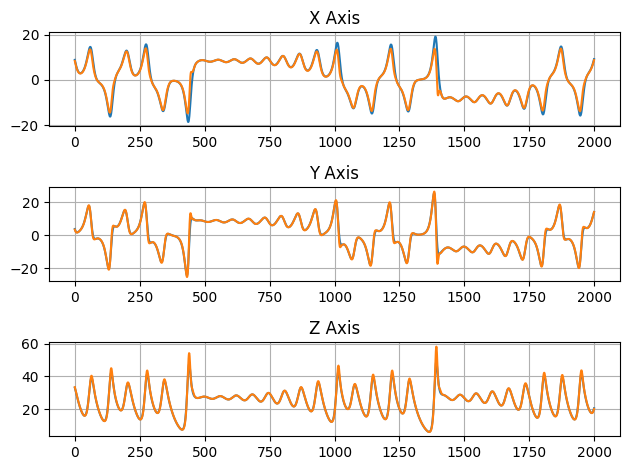

In [33]:
import matplotlib.pyplot as plt

f_lorentz   = qu.quaternionToEuler(x[8000:10000],  degrees = True )
f_predicted = qu.quaternionToEuler(y[1,8000:10000],  degrees = True )

# 3D plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*f_lorentz.T, lw=0.5, label='Real')
ax.plot(*f_predicted.T, lw=0.5, label='Real')
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")
ax.legend()
plt.show()

# Plot all components
TITLES = ["X Axis", "Y Axis", "Z Axis"]

for i, title in enumerate(TITLES):
    plt.subplot(3,1,i+1)
    plt.plot(f_lorentz[:,i])
    plt.plot(f_predicted[:,i])
    plt.title(title)
    plt.grid()
plt.tight_layout()
plt.show()